In [1]:
import pandas as pd
from osgeo import gdal
import math
import os
import glob
from PIL import Image # PIL library supports only TIF format but not newer TIFF
import numpy as np
from skimage import util, exposure

In [2]:
data_directory = '../data/'
asf_data_directory = data_directory + '3_processed_ASF_data/'
interpolated_AIS_data_directory = data_directory + '5_interpolated_AIS_data/'
#annotated_asf_data_directory = data_directory + '6_annotated_ASF_data/'
cutted_asf_data_directory = data_directory + '6_cutted_ASF_data/'
#sliced_asf_data_directory = data_directory +'7_sliced_ASF_data/'
results_directory = '../results/'

In [31]:
newest_results_file = "2023-01-13_00-58-29_full_data_df.csv"
full_data_df = pd.read_csv(results_directory + newest_results_file, index_col=0)
full_data_df

,asf_file,image_datetime,date,minLON,minLAT,maxLON,maxLAT,widthpx,heightpx,datetime_lower,datetime_upper,ais_file
0,subset_0_of_S1A_IW_GRDH_1SDV_20210106T015004_2...,2021-01-06 01:50:18.500,2021-01-06,-118.417484,33.310909,-117.675835,33.792945,8256,5366,2021-01-06 01:40:18.500,2021-01-06 02:00:18.500,AIS_2021_01_06.csv
1,subset_1_of_S1A_IW_GRDH_1SDV_20210106T135303_2...,2021-01-06 13:53:15.500,2021-01-06,-118.358644,31.787350,-116.685352,32.904135,18627,12432,2021-01-06 13:43:15.500,2021-01-06 14:03:15.500,AIS_2021_01_06.csv
2,subset_10_of_S1A_IW_GRDH_1SDV_20210307T015003_...,2021-03-07 01:50:17.500,2021-03-07,-118.500855,33.294096,-117.759475,33.776401,8253,5369,2021-03-07 01:40:17.500,2021-03-07 02:00:17.500,AIS_2021_03_07.csv
3,subset_11_of_S1B_IW_GRDH_1SDV_20210306T015804_...,2021-03-06 01:58:16.500,2021-03-06,-119.682261,34.259304,-119.487956,34.384619,2163,1395,2021-03-06 01:48:16.500,2021-03-06 02:08:16.500,AIS_2021_03_06.csv
4,subset_5_of_S1B_IW_GRDH_1SDV_20210306T015735_2...,2021-03-06 01:57:49.500,2021-03-06,-118.373353,33.409416,-117.973153,33.742602,4455,3709,2021-03-06 01:47:49.500,2021-03-06 02:07:49.500,AIS_2021_03_06.csv
5,subset_12_of_S1B_IW_GRDH_1SDV_20210406T014917_...,2021-04-06 01:49:29.500,2021-04-06,-117.504909,32.430804,-117.128335,32.677391,4192,2745,2021-04-06 01:39:29.500,2021-04-06 01:59:29.500,AIS_2021_04_06.csv
6,subset_13_of_S1B_IW_GRDH_1SDV_20210505T015737_...,2021-05-05 01:57:51.500,2021-05-05,-118.369253,33.310377,-117.952344,33.737795,4641,4758,2021-05-05 01:47:51.500,2021-05-05 02:07:51.500,AIS_2021_05_05.csv
7,subset_14_of_S1B_IW_GRDH_1SDV_20210505T015806_...,2021-05-05 01:58:18.500,2021-05-05,-120.182454,34.110307,-119.868223,34.312787,3498,2254,2021-05-05 01:48:18.500,2021-05-05 02:08:18.500,AIS_2021_05_05.csv
8,subset_15_of_S1B_IW_GRDH_1SDV_20210605T014920_...,2021-06-05 01:49:32.500,2021-06-05,-117.740009,32.063002,-117.092324,32.426101,7210,4042,2021-06-05 01:39:32.500,2021-06-05 01:59:32.500,AIS_2021_06_05.csv
9,subset_16_of_S1B_IW_GRDH_1SDV_20210605T135153_...,2021-06-05 13:52:05.500,2021-06-05,-118.573557,33.336484,-117.917068,33.761297,7308,4729,2021-06-05 13:42:05.500,2021-06-05 14:02:05.500,AIS_2021_06_05.csv


In [32]:
full_data_df = full_data_df.iloc[2:3]
full_data_df

,asf_file,image_datetime,date,minLON,minLAT,maxLON,maxLAT,widthpx,heightpx,datetime_lower,datetime_upper,ais_file
2,subset_10_of_S1A_IW_GRDH_1SDV_20210307T015003_...,2021-03-07 01:50:17.500,2021-03-07,-118.500855,33.294096,-117.759475,33.776401,8253,5369,2021-03-07 01:40:17.500,2021-03-07 02:00:17.500,AIS_2021_03_07.csv


### 1. Slice picture into pieces
https://stackoverflow.com/questions/50207292/how-to-convert-geotiff-to-jpg-in-python-or-java

C:\Users\user\AppData\Local\Temp\ipykernel_892\3103131224.py:54: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 4), dtype=np.object)


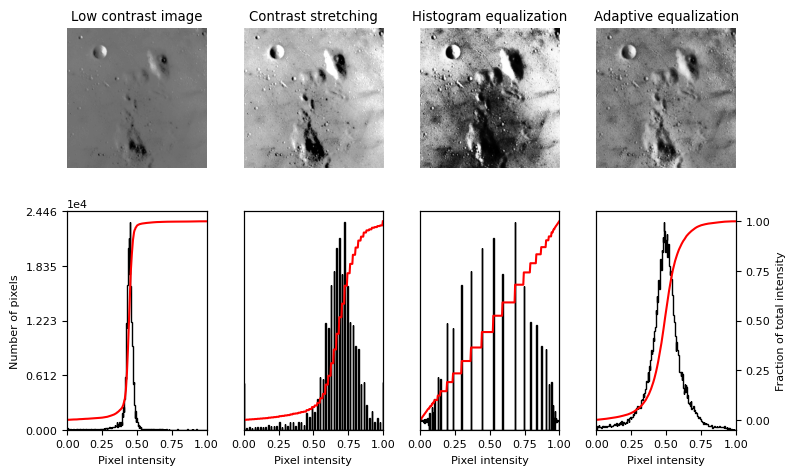

In [87]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [36]:
CHOSEN_PICTURE_SIZE = 640 #208 # pictures of example size 1000x1000 will be cutted

for index, row in full_data_df.iterrows():
    print(f"File: {index}")
    file_name = row['asf_file']
    print(f"File name: {file_name}")
    file_name_no_extension = file_name.strip('.tif')
    print(file_name_no_extension)
    working_dir = cutted_asf_data_directory + '/' + file_name_no_extension + '/'
    if not os.path.exists(working_dir):
        os.mkdir(working_dir)
    in_ds = gdal.Open(asf_data_directory + file_name)
    
    data = in_ds.ReadAsArray()
    #tmp = data[0,:,:]/data[1,:,:]
    tmp = np.divide(data[0,:,:], 
                      data[1,:,:], 
                      out=np.zeros_like(data[0,:,:]),
                      where=data[1,:,:]!=0) #only divide nonzeros else 0
    print(tmp.shape)
    # ADD 3rd channel to the picture
    tmp_ds = gdal.GetDriverByName('MEM').CreateCopy('', in_ds, 0)
    tmp_ds.AddBand()
    tmp_ds.GetRasterBand(3).WriteArray(tmp)
    
    # OPTION 1
    data = tmp_ds.ReadAsArray()
    for k in range(3):
        data[k,:,:] = data[k,:,:]/np.nanmax(data[k,:,:])
        #data[k,:,:] = data[k,:,:]*255
        # Histogram stretch
        print("mean before", np.mean(data[k,:,:]))
        #data[k,:,:] = exposure.equalize_hist(data[k,:,:])
        data[k,:,:] = exposure.rescale_intensity(data[k,:,:], (np.percentile(data[k,:,:], 2), np.percentile(data[k,:,:], 98)))
        #data[k,:,:] = data[k,:,:]*255
        print("mean after", np.mean(data[k,:,:]))
        tmp_ds.GetRasterBand(k+1).WriteArray(data[k,:,:])
    
    #data = exposure.equalize_hist(data)

    print(tmp.shape)
    print(data.shape)
    # convert image to gdal format
    # CUT THE IMAGE WITH 3 channels into tiles
    image_height = row['heightpx']
    image_width = row['widthpx']
    print(f"Image_size: {image_width}x{image_height} px")
    image_height = row['heightpx']
    nr_x_edges = math.ceil(image_width / CHOSEN_PICTURE_SIZE)
    nr_y_edges = math.ceil(image_height / CHOSEN_PICTURE_SIZE)
    print(f"X_edges: {nr_x_edges}, Y_edges: {nr_y_edges}")
    print(f"All_edges = x_edges*y_edges = {nr_x_edges*nr_y_edges}")
    # translate from TIFF to PNG
    #window = [i*CHOSEN_PICTURE_SIZE, j*CHOSEN_PICTURE_SIZE, CHOSEN_PICTURE_SIZE, CHOSEN_PICTURE_SIZE]
    options_list = [
        '-ot Byte',
        '-of PNG',
         '-b 1',
         '-b 2',
         '-b 3',
        '-scale'
    ]
    options_string = " ".join(options_list)
    kwargs = {
        'format': 'PNG', #JPEG, PNG, GTIFF
        #'srcWin': window,
        'options': options_string
    }
    out_ds = gdal.Translate(destName = working_dir + f'original_picture.png', #.tif, .png
                            srcDS = tmp_ds,                                     
                            **kwargs)
    print("original picture done")
    # cut the squares
    subset_number = 0
    for i in range(nr_x_edges):
        for j in range(nr_y_edges):
            subset_number += 1
            window = [i*CHOSEN_PICTURE_SIZE, j*CHOSEN_PICTURE_SIZE, CHOSEN_PICTURE_SIZE, CHOSEN_PICTURE_SIZE]
            # https://stackoverflow.com/questions/50207292/how-to-convert-geotiff-to-jpg-in-python-or-java
#             options_list = [
#                 '-ot Byte',
#                 '-of PNG',
#                 '-b 1',
#                 '-b 2',
#                 '-b 3',
#                 '-scale'
#             ]
            kwargs = {
                'format': 'PNG', #JPEG, PNG, GTIFF
                'srcWin': window
            }
            out_ds2 = gdal.Translate(destName = working_dir + f'subset{subset_number}.png', #.tif, .png
                                    srcDS = out_ds, #tmp_ds lub out_ds                                    
                                    **kwargs)
        
#             # OPTION 2
#             data=out_ds.ReadAsArray()
#             tmp_ds2 = gdal.GetDriverByName('MEM').CreateCopy('', out_ds, 0)
            
#             if np.isnan(data).any():
#                 print('nans detected')
#                 #continue
#             if np.all(data) == False:
#                 print('zeros detected')
#                 #continue
#             for k in range(3):
#                 data[k,:,:] = data[k,:,:]/np.nanmax(data[k,:,:])
#                 data[k,:,:] = data[k,:,:]*255
#                 data[k,:,:] = exposure.equalize_hist(data[k,:,:])
#                 tmp_ds2.GetRasterBand(k+1).WriteArray(data[k,:,:])
#             kwargs = {
#                 'format': 'PNG', #JPEG, PNG
#                 'srcWin': window
#             }

#             out_ds2 = gdal.Translate(destName = working_dir + f'subset{subset_number}.png', 
#                                     srcDS = tmp_ds2,                                     
#                                     **kwargs)
                
            out_width = out_ds2.RasterXSize
            out_height = out_ds2.RasterYSize
            print(f"Out picture {subset_number} width and height: {out_width}x{out_height} px")
    del in_ds
    del out_ds
    print()

File: 2
File name: subset_10_of_S1A_IW_GRDH_1SDV_20210307T015003_20210307T015032_036886_045698_BCE0_TC.tif
subset_10_of_S1A_IW_GRDH_1SDV_20210307T015003_20210307T015032_036886_045698_BCE0_TC
(5369, 8253)
mean before 1.1755607e-05
mean after 0.11339172
mean before 1.2615759e-05
mean after 0.14205366
mean before 0.00016530408
mean after 0.024949472
(5369, 8253)
(3, 5369, 8253)
Image_size: 8253x5369 px
X_edges: 13, Y_edges: 9
All_edges = x_edges*y_edges = 117
original picture done
Out picture 1 width and height: 640x640 px
Out picture 2 width and height: 640x640 px
Out picture 3 width and height: 640x640 px
Out picture 4 width and height: 640x640 px
Out picture 5 width and height: 640x640 px
Out picture 6 width and height: 640x640 px
Out picture 7 width and height: 640x640 px
Out picture 8 width and height: 640x640 px
Out picture 9 width and height: 640x640 px
Out picture 10 width and height: 640x640 px
Out picture 11 width and height: 640x640 px
Out picture 12 width and height: 640x640 p

In [53]:
tmp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [34]:
data[0,:,:]/data[1,:,:]

C:\Users\user\AppData\Local\Temp\ipykernel_892\433216579.py:1: RuntimeWarning: invalid value encountered in divide
  data[0,:,:]/data[1,:,:]


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [36]:
np.divide(data[0,:,:], 
          data[1,:,:])

C:\Users\user\AppData\Local\Temp\ipykernel_892\3931504529.py:1: RuntimeWarning: invalid value encountered in divide
  np.divide(data[0,:,:],


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [40]:
results_array = np.divide(data[0,:,:], 
                  data[1,:,:], 
                  out=np.zeros_like(data[0,:,:]),
                  where=data[1,:,:]!=0) #only divide nonzeros else 1
results_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [41]:
results_array.shape

(5005, 4862)

In [44]:
count = np.count_nonzero(results_array == 0)
count

7410544

In [45]:
count = np.count_nonzero(results_array == 1)
count

52

In [49]:
count = np.count_nonzero(results_array != 0)
count

16923766

In [ ]:
a = np.arange(10).reshape(2,5)
a[1,3] = 0
print(a)    #[[0 1 2 3 4], [5 6 7 0 9]]
a[0]/a[1]   # errors at 3/0
out = np.ones( (5) )  #preinit
np.divide(a[0],a[1], out=out, where=a[1]!=0) #only divide nonzeros else 1

### 2. Tag pictures

In [10]:
def calculate_px_from_lon2(row, xOrigin, pixelWidth):  
    return round((row['LON'] - xOrigin) / pixelWidth)

In [11]:
def calculate_px_from_lat2(row, yOrigin, pixelHeight):  
    return round((yOrigin - row['LAT']) / pixelHeight)

In [12]:
full_data_df

,asf_file,image_datetime,date,minLON,minLAT,maxLON,maxLAT,widthpx,heightpx,datetime_lower,datetime_upper,ais_file
0,subset_0_of_S1A_IW_GRDH_1SDV_20210106T015004_2...,2021-01-06 01:50:18.500,2021-01-06,-118.417484,33.310909,-117.675835,33.792945,8256,5366,2021-01-06 01:40:18.500,2021-01-06 02:00:18.500,AIS_2021_01_06.csv


In [30]:
SHIP_WIDTH_PX = 50 #50
SHIP_HEIGHT_PX = 50 #50
OBJECT_CLASS = 0
FILES_FORMAT_TO_PROCESS = '.png'

for index, row in full_data_df.iterrows():
    print(f"File: {index}")
    asf_file_name = row['asf_file'].strip(".tif")
    print(f"ASF file name: {asf_file_name}")
    ais_file_name = 'interpolated_processed_' + row['ais_file']
    print(f"AIS file name: {ais_file_name}")
    ais_file_df = pd.read_csv(interpolated_AIS_data_directory + ais_file_name, index_col=0)
    # HERE STARTS THE DIFFERENCE
    directory = cutted_asf_data_directory + asf_file_name
    print(f'directory: {directory}')
    if os.path.exists(directory):
        pictures=list()
        for file in os.listdir(directory):
            if file.endswith(FILES_FORMAT_TO_PROCESS):
                pictures.append(file)
        print(pictures)
        for picture in pictures:
            print(f'picture: {picture}')
            picture_name = picture.strip(FILES_FORMAT_TO_PROCESS)
            print(f'picture_name: {picture_name}')
            in_ds = gdal.Open(directory + '/' + picture)
            #print(in_ds)
            image_width = in_ds.RasterXSize
            image_height = in_ds.RasterYSize
            geo_transform = in_ds.GetGeoTransform()

            minx = geo_transform[0] #minLON
            miny = geo_transform[3] + image_width*geo_transform[4] + image_height*geo_transform[5] #minLAT
            maxx = geo_transform[0] + image_width*geo_transform[1] + image_height*geo_transform[2] #maxLON
            maxy = geo_transform[3] #maxLAT
            
            xOrigin = geo_transform[0] # NEEDED
            yOrigin = geo_transform[3] # NEEDED
            pixelWidth = geo_transform[1] # NEEDED
            pixelHeight = -geo_transform[5] # NEEDED
            print(f"image_width: {image_width}, image_height: {image_height}")
            #print(f"pixel_width: {pixelWidth}, pixel_height: {pixelHeight}")
            print(f"xOrigin: {xOrigin}, yOrigin: {yOrigin}")
            #display(ais_file_df.head())
            
            # Restrict AIS data by the given conditions
            # condition for latitude: between 19.193 and 21.1203
            condition1 = (ais_file_df.LAT > miny) & (ais_file_df.LAT < maxy)
            # condition for latitude: between -157.0894 and -154.4233
            condition2 = (ais_file_df.LON > minx) & (ais_file_df.LON < maxx)
            # final dataframe
            target_area = ais_file_df[condition1 & condition2].copy().reset_index(drop=True)
            #display(target_area)
            
            # Further work
            if len(target_area) != 0:
                print('##############')
                print('SHIPS DETECTED')
                print('##############')
                # TODO: if to save empty txt file?
                # YOLO format do not need empty files for pictures
                for index, row in target_area.iterrows():
                    target_area['LONpx_X2'] = target_area.apply(lambda row: calculate_px_from_lon2(row, xOrigin, pixelWidth), axis=1)
                    target_area['LATpx_Y2'] = target_area.apply(lambda row: calculate_px_from_lat2(row, yOrigin, pixelHeight), axis=1)
                    display(target_area.head())
                    
                current_file = directory + '/' + picture_name + '.txt'
                if os.path.exists(current_file):
                    os.remove(current_file) #remove old files
                for index, row in target_area.iterrows():
                    file_object = open(current_file, 'a')
                    #OBJECT_CLASS, SHIP_WIDTH_PX, SHIP_HEIGHT_PX
                    #print("before normalization")
                    #print("LONpx_X2", row['LONpx_X2'])
                    #print("LATpx_Y2", row['LATpx_Y2'])
                    X_CENTER_AXIS_VALUE = row['LONpx_X2']
                    Y_CENTER_AXIS_VALUE = row['LATpx_Y2']
                    #print(OBJECT_CLASS, X_CENTER_AXIS_VALUE, Y_CENTER_AXIS_VALUE, SHIP_WIDTH_PX, SHIP_HEIGHT_PX)
                    #print("after normalization")
                    #X_CENTER_AXIS_VALUE = (X_CENTER_AXIS_VALUE + SHIP_WIDTH_PX/2) / image_width
                    #Y_CENTER_AXIS_VALUE = (Y_CENTER_AXIS_VALUE + SHIP_HEIGHT_PX/2) / image_height
                    X_CENTER_AXIS_VALUE = X_CENTER_AXIS_VALUE / image_width
                    Y_CENTER_AXIS_VALUE = Y_CENTER_AXIS_VALUE / image_height
                    SHIP_WIDTH_normalized = SHIP_WIDTH_PX / image_width
                    SHIP_HEIGHT_normalized = SHIP_HEIGHT_PX / image_height
                    #print(OBJECT_CLASS, X_CENTER_AXIS_VALUE, Y_CENTER_AXIS_VALUE, SHIP_WIDTH_normalized, SHIP_HEIGHT_normalized)
                    string_to_write = f"{OBJECT_CLASS} {X_CENTER_AXIS_VALUE} {Y_CENTER_AXIS_VALUE} {SHIP_WIDTH_normalized} {SHIP_HEIGHT_normalized}\n"
                    file_object.write(string_to_write)
                    # Close the file       
                    file_object.close()
            else:
                print()
                #print('Sorry, no ships on the selected area')
                #file_object = open(directory + '/' + picture_name + '.txt', 'a')
                #file_object.close()
            print()
    else:
        print('ERROR!! no picture data')
        print('TRY ANNOTATION AGAIN')
        continue

File: 0
ASF file name: subset_0_of_S1A_IW_GRDH_1SDV_20210106T015004_20210106T015033_036011_04381A_71E9_TC
AIS file name: interpolated_processed_AIS_2021_01_06.csv
directory: ../data/6_cutted_ASF_data/subset_0_of_S1A_IW_GRDH_1SDV_20210106T015004_20210106T015033_036011_04381A_71E9_TC
['original_picture-eq2-255.png', 'original_picture-eq2_per_channel.png', 'original_picture-nobyte.png', 'original_picture-noeq.png', 'original_picture-noscalwe.png', 'original_picture-rescale.png', 'original_picture-rescale255.png', 'original_picture-with_eq.png', 'original_picture.png', 'subset1.png', 'subset10.png', 'subset100.png', 'subset101.png', 'subset102.png', 'subset103.png', 'subset104.png', 'subset105.png', 'subset106.png', 'subset107.png', 'subset108.png', 'subset109.png', 'subset11.png', 'subset110.png', 'subset111.png', 'subset112.png', 'subset113.png', 'subset114.png', 'subset115.png', 'subset116.png', 'subset117.png', 'subset12.png', 'subset13.png', 'subset14.png', 'subset15.png', 'subset16.p

image_width: 640, image_height: 640
xOrigin: -117.95484044970567, yOrigin: 33.706556419


picture: subset56.png
picture_name: subset56
image_width: 640, image_height: 640
xOrigin: -117.95484044970567, yOrigin: 33.64908158237828


picture: subset57.png
picture_name: subset57
image_width: 640, image_height: 640
xOrigin: -117.95484044970567, yOrigin: 33.591606745756565


picture: subset58.png
picture_name: subset58
image_width: 640, image_height: 640
xOrigin: -117.95484044970567, yOrigin: 33.53413190913484


picture: subset59.png
picture_name: subset59
image_width: 640, image_height: 640
xOrigin: -117.95484044970567, yOrigin: 33.47665707251312


picture: subset6.png
picture_name: subset6
image_width: 640, image_height: 640
xOrigin: -118.299835315, yOrigin: 33.419182235891405


picture: subset60.png
picture_name: subset60
image_width: 640, image_height: 640
xOrigin: -117.95484044970567, yOrigin: 33.419182235891405


picture: subset61.png
picture_name: subset61
image_width: 640, image_heigh

In [16]:
print('hi')

hi


# OLD

In [47]:
CHOSEN_PICTURE_SIZE = 208 # pictures of example size 1000x1000 will be cutted

for index, row in full_data_df.iterrows():
    print(f"File: {index}")
    file_name = row['asf_file']
    print(f"File name: {file_name}")
    file_name_no_extension = file_name.strip('.tif')
    print(file_name_no_extension)
    working_dir = cutted_asf_data_directory + '/' + file_name_no_extension + '/'
    if not os.path.exists(working_dir):
        os.mkdir(working_dir)
    in_ds = gdal.Open(asf_data_directory + file_name)
    data=in_ds.ReadAsArray()
    tmp = data[0,:,:]/data[1,:,:]
    tmpEq = exposure.equalize_hist(tmp)
    
    # ADD 3rd channel to the picture
    tmp_ds = gdal.GetDriverByName('MEM').CreateCopy('', in_ds, 0)
    tmp_ds.AddBand()
    tmp_ds.GetRasterBand(3).WriteArray(tmp)

    #dst_ds = gdal.GetDriverByName('JPEG').CreateCopy(output_path, tmp_ds, 0)
    #
#     in_ds.AddBand()
#     data=in_ds.ReadAsArray()
#     tmp = data[0,:,:]/data[1,:,:]
#     in_ds.GetRasterBand(3).WriteArray(tmp)
#     data=in_ds.ReadAsArray()
#     tmp = data[0,:,:]/data[1,:,:]
#     tmp = np.expand_dims(tmp,axis=0)
    print(tmp.shape)
#     print(data.shape)
#     data = np.vstack((data,tmp))
    print(data.shape)
    # convert image to gdal format
    
    # CUT THE IMAGE WITH 3 channels into tiles
    image_height = row['heightpx']
    image_width = row['widthpx']
    print(f"Image_size: {image_width}x{image_height} px")
    image_height = row['heightpx']
    nr_x_edges = math.ceil(image_width / CHOSEN_PICTURE_SIZE)
    nr_y_edges = math.ceil(image_height / CHOSEN_PICTURE_SIZE)
    print(f"X_edges: {nr_x_edges}, Y_edges: {nr_y_edges}")
    print(f"All_edges = x_edges*y_edges = {nr_x_edges*nr_y_edges}")
    # cut the squares
    subset_number = 0
    for i in range(nr_x_edges):
        for j in range(nr_y_edges):
            #print(i, j)
            tmpds = 
            subset_number += 1
            window = [i*CHOSEN_PICTURE_SIZE, j*CHOSEN_PICTURE_SIZE, CHOSEN_PICTURE_SIZE, CHOSEN_PICTURE_SIZE]
            #out_ds = gdal.Translate(cutted_asf_data_directory + file_name_no_extension + f'_subset{subset_number}.tif', in_ds, srcWin=window)
            kwargs = {
                'format': 'GTIFF', #JPEG, PNG
                'srcWin': window
            }
            out_ds = gdal.Translate(destName = working_dir + f'subset{subset_number}.tif', 
                                    srcDS = tmp_ds,                                     
                                    **kwargs)
            data_ds = 
            out_width = out_ds.RasterXSize
            out_height = out_ds.RasterYSize
            print(f"Out picture {subset_number} width and height: {out_width}x{out_height} px")
    del in_ds
    del out_ds
    print()

SyntaxError: invalid syntax (2443592351.py, line 16)

In [47]:
CHOSEN_PICTURE_SIZE = 208 # pictures of example size 1000x1000 will be cutted

for index, row in full_data_df.iterrows():
    print(f"File: {index}")
    file_name = row['asf_file']
    print(f"File name: {file_name}")
    file_name_no_extension = file_name.strip('.tif')
    print(file_name_no_extension)
    working_dir = cutted_asf_data_directory + '/' + file_name_no_extension + '/'
    if not os.path.exists(working_dir):
        os.mkdir(working_dir)
    in_ds = gdal.Open(asf_data_directory + file_name)
    data=in_ds.ReadAsArray()
    tmp = data[0,:,:]/data[1,:,:]
    tmpEq = exposure.equalize_hist(tmp)
    
    # ADD 3rd channel to the picture
    tmp_ds = gdal.GetDriverByName('MEM').CreateCopy('', in_ds, 0)
    tmp_ds.AddBand()
    tmp_ds.GetRasterBand(3).WriteArray(tmp)

    #dst_ds = gdal.GetDriverByName('JPEG').CreateCopy(output_path, tmp_ds, 0)
    #
#     in_ds.AddBand()
#     data=in_ds.ReadAsArray()
#     tmp = data[0,:,:]/data[1,:,:]
#     in_ds.GetRasterBand(3).WriteArray(tmp)
#     data=in_ds.ReadAsArray()
#     tmp = data[0,:,:]/data[1,:,:]
#     tmp = np.expand_dims(tmp,axis=0)
    print(tmp.shape)
#     print(data.shape)
#     data = np.vstack((data,tmp))
    print(data.shape)
    # convert image to gdal format
    
    # CUT THE IMAGE WITH 3 channels into tiles
    image_height = row['heightpx']
    image_width = row['widthpx']
    print(f"Image_size: {image_width}x{image_height} px")
    image_height = row['heightpx']
    nr_x_edges = math.ceil(image_width / CHOSEN_PICTURE_SIZE)
    nr_y_edges = math.ceil(image_height / CHOSEN_PICTURE_SIZE)
    print(f"X_edges: {nr_x_edges}, Y_edges: {nr_y_edges}")
    print(f"All_edges = x_edges*y_edges = {nr_x_edges*nr_y_edges}")
    # cut the squares
    subset_number = 0
    for i in range(nr_x_edges):
        for j in range(nr_y_edges):
            #print(i, j)
            tmpds = 
            subset_number += 1
            window = [i*CHOSEN_PICTURE_SIZE, j*CHOSEN_PICTURE_SIZE, CHOSEN_PICTURE_SIZE, CHOSEN_PICTURE_SIZE]
            #out_ds = gdal.Translate(cutted_asf_data_directory + file_name_no_extension + f'_subset{subset_number}.tif', in_ds, srcWin=window)
            kwargs = {
                'format': 'GTIFF', #JPEG, PNG
                'srcWin': window
            }
            out_ds = gdal.Translate(destName = working_dir + f'subset{subset_number}.tif', 
                                    srcDS = tmp_ds,                                     
                                    **kwargs)
            data_ds = 
            out_width = out_ds.RasterXSize
            out_height = out_ds.RasterYSize
            print(f"Out picture {subset_number} width and height: {out_width}x{out_height} px")
    del in_ds
    del out_ds
    print()

SyntaxError: invalid syntax (2443592351.py, line 16)